In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [7]:
import sys
sys.path.append("..")

In [31]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from coordination.model.vocalic_model import VocalicModel

In [26]:
# Inspect saved Inference Data onject
DATA_DIR="/Users/paulosoares/data/publication_2023/asist_usar_task/inferences/vocalic/2_features/T000671"
with open(f"{DATA_DIR}/inference_data.pkl", "rb") as f:
    idata = pickle.load(f)

idata

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [54]:
idata.observed_data["obs_vocalic"].sel(vocalic_feature="intensity")

<xarray.DataArray 'obs_vocalic' (vocalic_time: 259)>
array([3.27418736e-01, 3.07151758e-01, 1.87810257e-01, 1.26309329e-01,
       4.33812955e-01, 2.25866361e-01, 2.27740606e-01, 3.11939286e-01,
       2.33310604e-01, 1.75774037e-01, 3.18028621e-01, 3.07884338e-01,
       4.11312586e-01, 3.39334425e-01, 2.52579927e-01, 1.79158902e-01,
       2.40849325e-01, 3.04070259e-01, 2.65243551e-01, 4.45232821e-01,
       3.44900546e-01, 2.72314978e-01, 1.03544450e-01, 3.11246176e-01,
       4.51853520e-01, 9.73387503e-02, 3.42241716e-01, 1.11075738e-01,
       1.83281116e-01, 5.00525301e-02, 2.92544946e-01, 2.80149839e-01,
       3.03096321e-01, 9.14406416e-02, 1.00000000e+00, 1.37232868e-01,
       2.88069828e-01, 7.64137386e-02, 3.59679798e-01, 2.17794998e-01,
       2.69318066e-01, 6.35344637e-02, 2.34673983e-01, 5.14686380e-01,
       2.55541014e-01, 1.43590992e-01, 3.75255654e-01, 1.59195966e-01,
       2.43542106e-01, 1.44290084e-01, 4.12320729e-01, 2.24236183e-01,
       3.39971877e-01, 4.57606664e-01, 2.76378623e-01, 1.47186770e-01,
       1.81880614e-01, 2.33978210e-01, 1.70849229e-01, 1.45322921e-01,
       1.76924109e-01, 1.44194751e-01, 7.08416730e-01, 3.72400878e-01,
       3.97472654e-01, 9.10679767e-02, 3.90760419e-01, 2.57780419e-01,
       1.76882789e-01, 2.69502876e-01, 6.60433268e-01, 2.91374161e-01,
       1.65361384e-01, 3.35807423e-01, 2.05417076e-01, 3.50332119e-01,
       7.79939734e-02, 3.09101977e-01, 2.34120069e-01, 2.14478278e-01,
...
       6.41763115e-01, 3.58226755e-01, 2.19536168e-01, 1.65137979e-01,
       2.67084890e-01, 8.70192910e-02, 3.76992617e-01, 9.38968615e-02,
       6.40432292e-01, 3.62424815e-01, 1.13390231e-01, 1.40007960e-01,
       5.76131930e-02, 3.51074914e-01, 6.05326473e-01, 2.31941709e-01,
       1.03431593e-01, 3.03072318e-01, 3.31522953e-01, 2.75021958e-01,
       3.40678589e-01, 3.54783813e-01, 9.64010328e-02, 2.80933892e-01,
       2.18055427e-01, 2.03872163e-01, 1.45495968e-01, 1.00856031e-01,
       4.44821741e-01, 3.53208930e-01, 2.09145620e-01, 2.08857055e-01,
       4.50727461e-01, 6.75339614e-01, 1.56822356e-01, 4.41895290e-01,
       2.86702888e-01, 2.70835793e-01, 1.90598465e-01, 2.50948952e-01,
       5.14532532e-02, 1.75229075e-01, 1.76084252e-01, 1.33617494e-01,
       2.08887259e-01, 1.09080967e-01, 7.82966964e-02, 2.81121087e-01,
       1.46402586e-01, 1.22399496e-01, 1.46565057e-01, 2.15956668e-01,
       3.80106758e-02, 1.77170970e-01, 2.30256918e-01, 2.68958863e-01,
       1.67840070e-01, 1.80145201e-01, 3.67598175e-01, 1.98753293e-01,
       0.00000000e+00, 1.28999570e-01, 2.83910459e-02, 3.83255830e-01,
       2.24841664e-01, 3.75677462e-01, 1.42957181e-01, 4.52125635e-01,
       6.68059312e-01, 2.93599436e-01, 4.22286832e-02, 2.00140654e-01,
       3.45513789e-01, 8.76997676e-02, 3.14689753e-01, 2.99703269e-01,
       1.66069643e-01, 3.07873271e-01, 2.24453116e-01])
Coordinates:
    vocalic_feature  <U9 'intensity'
  * vocalic_time     (vocalic_time) int64 0 1 2 3 4 5 ... 254 255 256 257 258

Text(0, 0.5, 'Coordination')

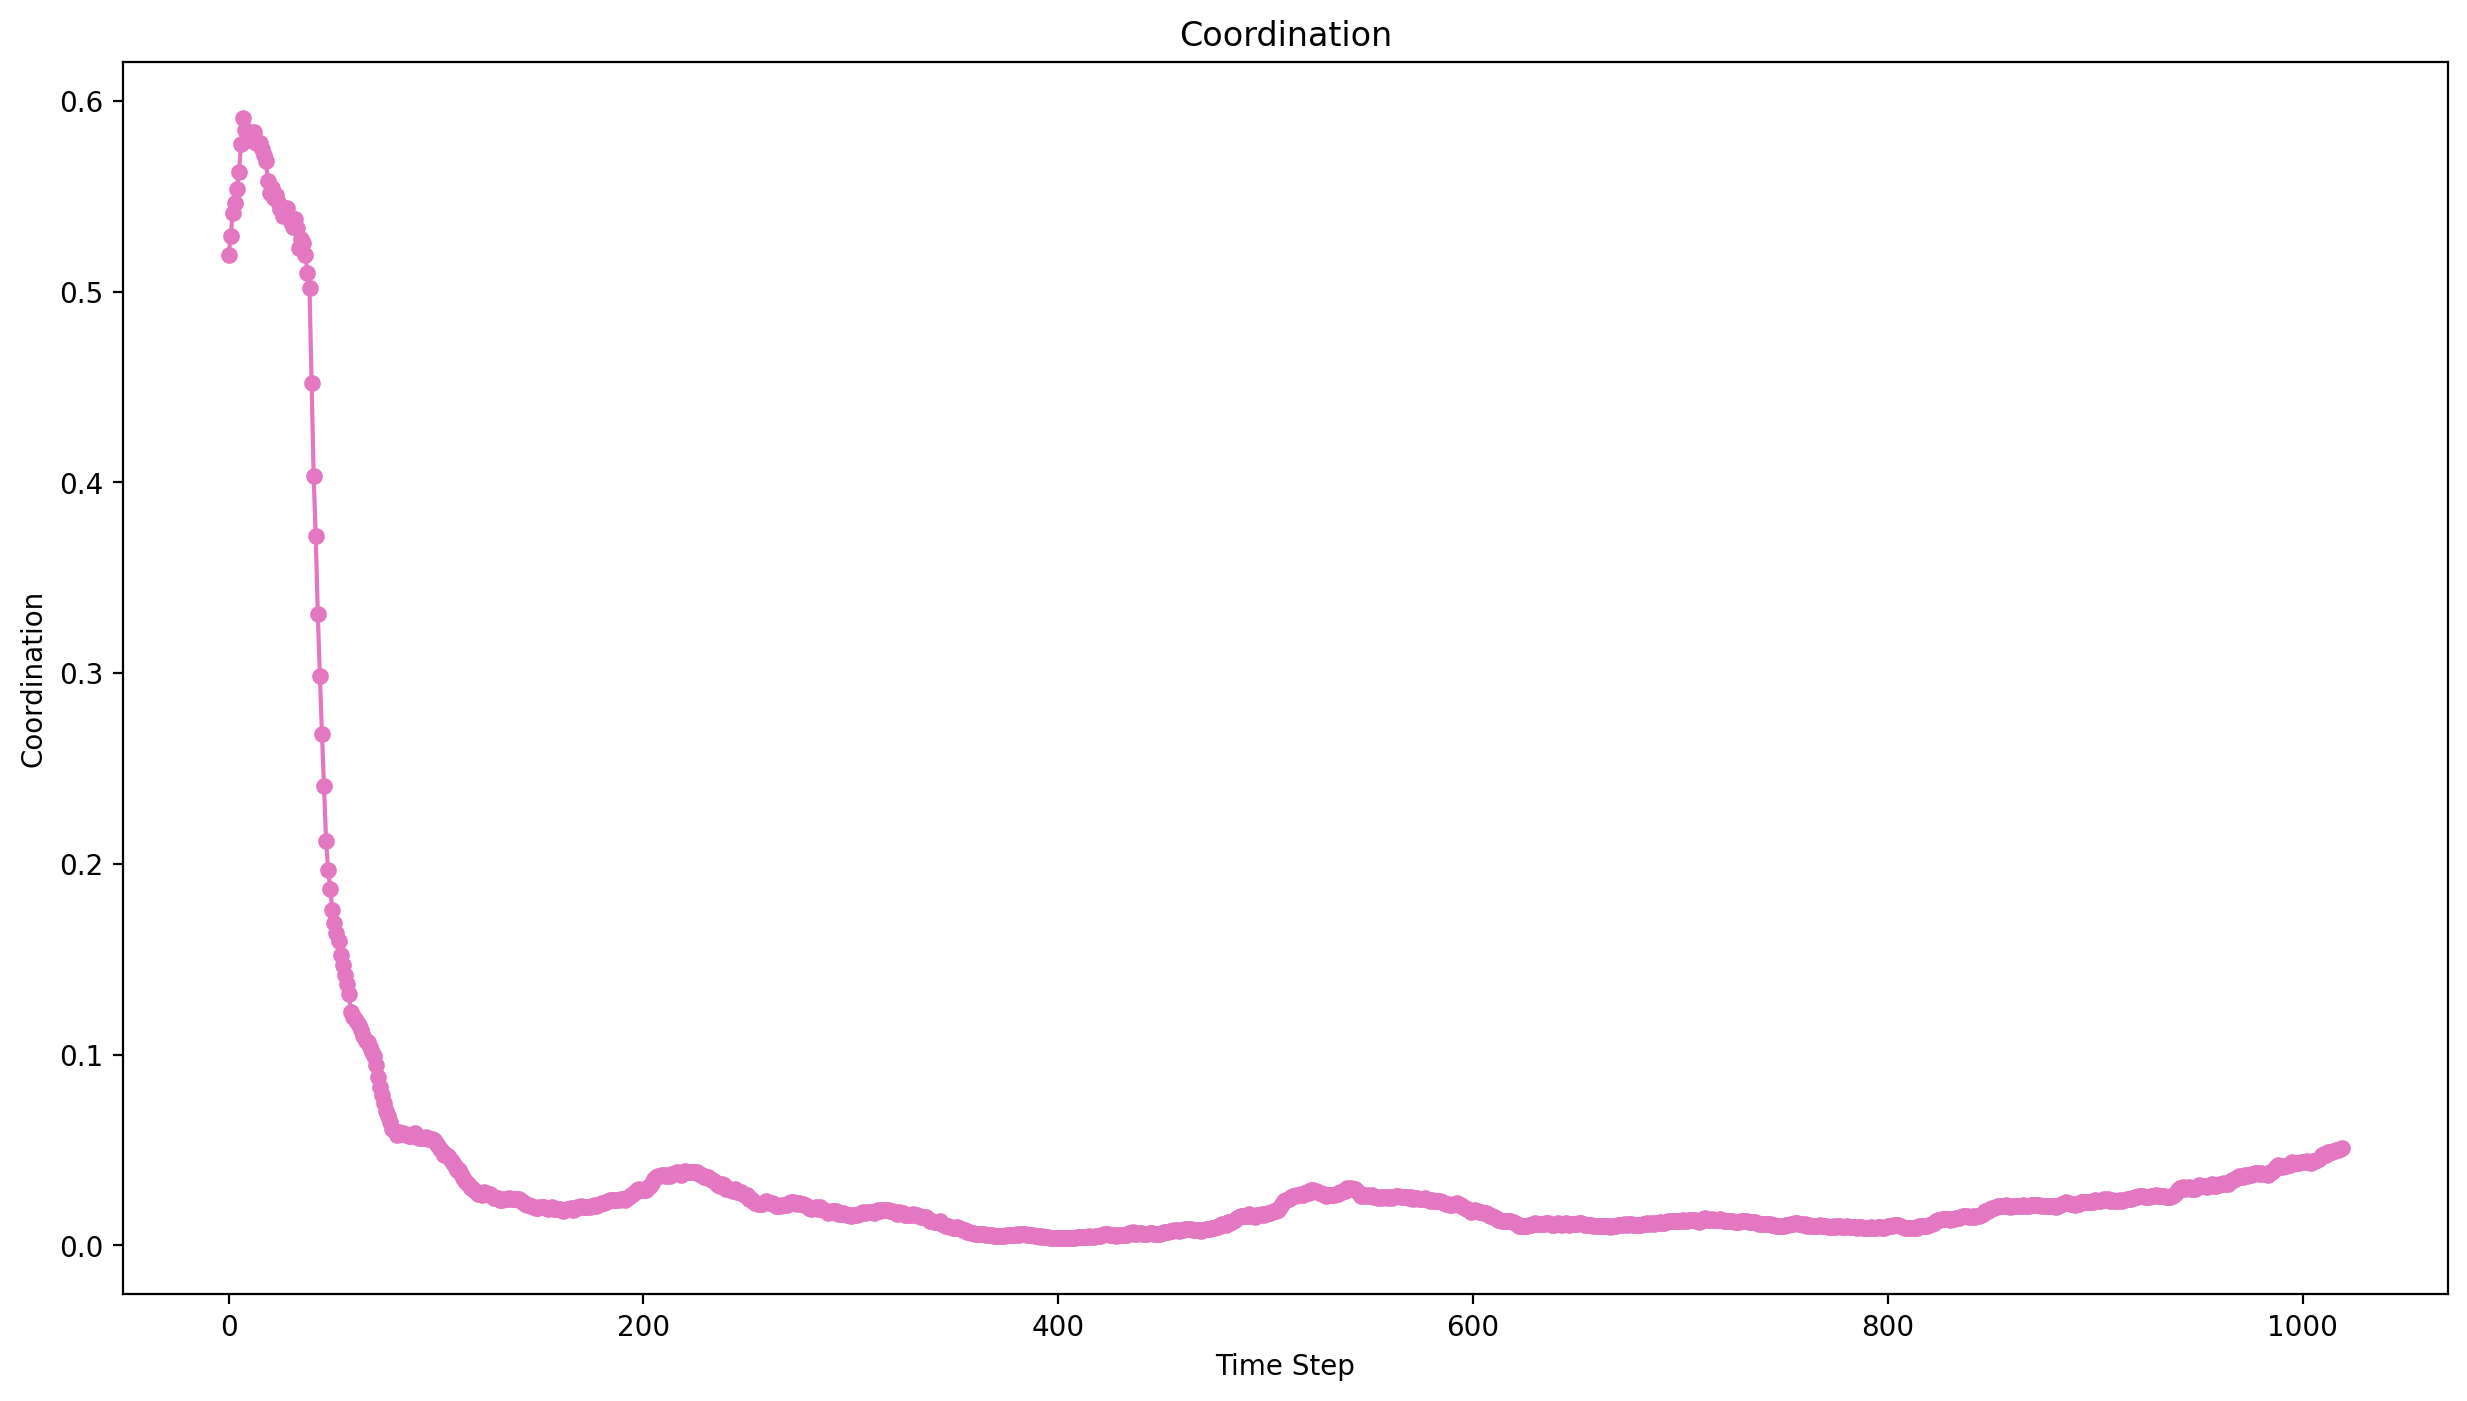

In [29]:
posterior_samples = VocalicModel.inference_data_to_posterior_samples(idata)

T = posterior_samples.coordination.sizes["coordination_time"]
C = posterior_samples.coordination.sizes["chain"]
N = posterior_samples.coordination.sizes["draw"]
stacked_coordination_samples = posterior_samples.coordination.stack(chain_plus_draw=("chain", "draw"))

fig = plt.figure(figsize=(15, 8))
# plt.plot(np.arange(T)[:, None].repeat(N * C, axis=1), stacked_coordination_samples, color="tab:blue", alpha=0.3)
plt.plot(np.arange(T), posterior_samples.coordination.mean(dim=["chain", "draw"]), color="tab:pink", alpha=1,
         marker="o", markersize=5)
plt.title(f"Coordination")
plt.xlabel(f"Time Step")
plt.ylabel(f"Coordination")

In [46]:
from IPython.core.display import display,HTML

df = pd.DataFrame([['A231', 'Book', 5, 3, 150], 
                   ['M441', 'Magic Staff', 10, 7, 200]],
                   columns = ['Code', 'Name', 'Price', 'Net', 'Sales'])

# your images
images1 = ['Images/2_features/T000671/plots/posterior/coordination.png',
           'Images/2_features/T000671/plots/posterior/coordination.png'] 


df['imageUrls'] = images1


# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="400" >'

pd.set_option('display.max_colwidth', None)

image_cols = ['imageUrls']  #<- define which columns will be used to convert to html

# Create the dictionariy to be passed as formatters
format_dict = {}
for image_col in image_cols:
    format_dict[image_col] = path_to_image_html


display(HTML(df.to_html(escape=False ,formatters=format_dict)))

/var/folders/xy/pk0wh2pd6x12m__j8r7ql0f40000gs/T/ipykernel_2644/2968246979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display,HTML


,Code,Name,Price,Net,Sales,imageUrls
0,A231,Book,5,3,150,
1,M441,Magic Staff,10,7,200,


In [56]:
coordination = posterior_samples.coordination.mean(dim=["chain", "draw"])
evidence = pd.read_csv("/Users/paulosoares/data/publication_2023/asist_usar_task/datasets/tomcat_advisor/usar_1_hz_coord.csv", index_col=0)

experiment_id            mission_start_time_utc  \
0       T000812  2022-07-02 19:22:59.721000+00:00   
0       T000671  2022-05-17 22:34:15.237000+00:00   
0       T000841  2022-07-10 01:56:02.590000+00:00   
0       T000822  2022-07-07 23:03:39.112000+00:00   
0       T000792  2022-06-25 23:09:52.442000+00:00   

               mission_end_time_utc              trial_start_time_utc  \
0  2022-07-02 19:40:03.719000+00:00  2022-07-02 19:14:37.078200+00:00   
0  2022-05-17 22:51:19.239000+00:00  2022-05-17 22:30:03.231300+00:00   
0  2022-07-10 02:13:06.592000+00:00  2022-07-10 01:54:02.802600+00:00   
0  2022-07-07 23:20:43.115000+00:00  2022-07-07 22:58:54.507500+00:00   
0  2022-06-25 23:26:56.444000+00:00  2022-06-25 23:03:34.339900+00:00   

                 trial_end_time_utc  experiment_duration_in_seconds  \
0  2022-07-02 19:49:11.353900+00:00                            1020   
0  2022-05-17 22:54:52.235900+00:00                            1020   
0  2022-07-10 02:18:06.155900+00:00                            1020   
0  2022-07-07 23:25:11.670000+00:00                            1020   
0  2022-06-25 23:33:13.621000+00:00                            1020   

   coordination_frequency  num_time_steps_in_coordination_scale  team_score  \
0                       1                                  1020         360   
0                       1                                  1020         470   
0                       1                                  1020         500   
0                       1                                  1020         290   
0                       1                                  1020         750   

  blue_player_id  ...  \
0        E001153  ...   
0        E000855  ...   
0        E001268  ...   
0        E001214  ...   
0        E001141  ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    vocalic_time_steps_in_coordination_scale  \
0                                                                                                                                                                                                                                                                                                                                                                        [1, 6, 9, 12, 15, 22, 25, 29, 35, 41, 47, 48, 52, 53, 57, 63, 64, 70, 74, 79, 85, 91, 96, 99, 101, 127, 136, 137, 143, 152, 153, 171, 174, 179, 180, 185, 194, 195, 197, 212, 216, 220, 225, 231, 235, 239, 244, 253, 262, 264, 266, 272, 274, 279, 282, 289, 294, 299, 304, 312, 315, 316, 320, 321, 326, 332, 336, 369, 372, 375, 380, 388, 389, 397, 405, 408, 409, 417, 418, 421, 432, 434, 438, 440, 445, 450, 452, 460, 469, 474, 477, 485, 514, 522, 524, 527, 532, 534, 544, 546, 552, 554, 557, 558, 562, 563, 569, 577, 578, 580, 581, 588, 595, 611, 613, 6

In [79]:
results_df = pd.DataFrame()
results_df["experiment_id"] = evidence["experiment_id"]
results_df["score"] = evidence["team_score"]
results_df["c_mean"] = coordination.mean()
results_df["c_median"] = coordination.median()
results_df["c_var"] = coordination.var()
results_df["c_25p"] = coordination.quantile(.25)
results_df["c_75p"] = coordination.quantile(.75)
results_df["c_95p"] = coordination.quantile(.95)
results_df["c_99p"] = coordination.quantile(.99)
results_df.sort_values("c_mean")

KeyError: 'avg_coordination'